In [10]:
import numpy as np
import pandas as pd
from drn_interactions.load import load_neurons_derived
from drn_interactions.spikes import SpikesHandler
from drn_interactions.surrogates import shuffle_spikes
from scipy.stats import zscore
from drn_interactions.popcup import PopulationCoupling
from tqdm.notebook import tqdm
from scipy.stats import percentileofscore

def get_pval(row, df_reps, abs=True):
    reps = df_reps[row.neuron_id].values
    value = row.cc
    if abs:
        reps = np.abs(reps)
        value = np.abs(value)
    pvalue = np.mean(reps >= value)
    return pvalue

def get_popcup_reps(sh, nboot=100):
    df_reps = []
    for i in tqdm(range(nboot)):
        sh_sur = shuffle_spikes(sh)
        df_surr = sh_sur.binned_piv
        df_surr_res = PopulationCoupling(nlags=100).fit(df_surr).get_couplings(method="zerolag")
        df_surr_res["rep_idx"] = i
        df_reps.append(df_surr_res)
    df_reps = pd.concat(df_reps)
    df_reps = df_reps.pivot(columns="neuron_id", index="rep_idx", values="cc")
    return df_reps

def get_popcup(sh, nboot=10, nlags=100, method="zerolag"):
    df = sh.binned_piv
    df_true = PopulationCoupling(nlags=nlags).fit(df).get_couplings(method=method)
    df_reps = get_popcup_reps(sh, nboot=nboot)
    df_true["pval"] = df_true.apply(get_pval, df_reps=df_reps, axis=1)
    return df_true


In [11]:
neurons = load_neurons_derived()
sessions = neurons["session_name"].unique()
NBOOT = 5


sh = SpikesHandler("pre", bin_width=1, session_names=[sessions[9]], t_start=0, t_stop=1800)
df_res = get_popcup(sh, nboot=NBOOT)

  0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
# Example popcup

In [6]:
# Change with Brain State

In [14]:
# Change with Foot Shock


<AxesSubplot:xlabel='bin'>

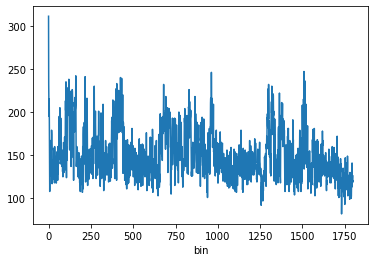

In [15]:
sh_sur.binned_piv.sum(axis=1).plot()